In [1]:
import numpy as np
import qtree
import networkx as nx
import matplotlib.pyplot as plt
import copy

import utils

%load_ext autoreload
%autoreload 2
%cd ..

ModuleNotFoundError("No module named 'tensorflow'")
/home/dali/anl/qsim/qtree


In [2]:
def get_locale_peo(old_graph, rule):
    # This is far below computationally effective
    graph = copy.deepcopy(old_graph)
    
    path= []
    vals = []
    while graph.number_of_nodes():
        #nodes = sorted(graph.nodes, key=int)
        nodes = list(graph.nodes)
        rule_ = lambda n: rule(graph, n)
        costs = list(map(rule_, nodes))
        _idx = np.argmin(costs)
        vals.append(costs[_idx])
        node = nodes[_idx]
        path.append(node)
        qtree.graph_model.eliminate_node(graph, node)
    return path, vals


In [7]:
nqubits, circ = utils.test_circ('./test_circuits/', 6, depth=15)
graph = qtree.graph_model.circ2graph(nqubits, circ)

2020-03-02 16:50:59,428- INFO•	reading file ./test_circuits//inst/cz_v2/6x6/inst_6x6_15_0.txt
2020-03-02 16:50:59,440- INFO•	There are 36 qubits in circuit
2020-03-02 16:50:59,480- INFO•	Generated graph with 225 nodes and 375 edges


In [8]:
def profile_grpaph(graph):
    peo, tw = qtree.graph_model.get_peo(graph)
    print('Treewidth:', tw)
    graph_opt, _ = utils.reorder_graph(graph, peo)

    #-
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    plt.sca(axs[0])
    plt.title('Original ')
    nx.draw_kamada_kawai(graph, node_size=20, with_labels=True)
    plt.sca(axs[1])
    plt.title('Reordered ')
    nx.draw_kamada_kawai(graph_opt, node_size=20, with_labels=True)

    mems, flops = qtree.graph_model.cost_estimator(graph)
    mems_opt, flops_opt = qtree.graph_model.cost_estimator(graph_opt)

    npeo, nghs = get_locale_peo(graph, utils.n_neighbors)
    graph_opt_loc, _ = utils.reorder_graph(graph, npeo)
    mems_loc, flops_loc = qtree.graph_model.cost_estimator(graph_opt_loc)

    #-
    f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,4))
    plt.sca(axs[0])
    plt.title('Unchanged order')
    utils.plot_cost(mems, flops)

    plt.sca(axs[1])
    plt.title('Quickbb')
    utils.plot_cost(mems_opt, flops_opt)

    plt.sca(axs[2])
    plt.title('Local ordering:')
    utils.plot_cost(mems_loc, flops_loc)

    nodes, ngh_loc = utils.get_neighbours_path(graph_opt_loc)
    nodes, ngh = utils.get_neighbours_path(graph_opt)

    print(f'local: {max(ngh_loc)}, quickbb: {max(ngh)}')
    plt.figure()
    #-
    plt.plot(nodes, ngh_loc, label=f'Node degree:  sum={sum(ngh_loc)}')
    plt.plot(nodes, ngh, label=f'Quickbb: sum={sum(ngh)}')
    plt.grid()
    plt.legend()

2020-03-02 16:51:33,669- INFO•	reading file ./test_circuits//inst/cz_v2/5x5/inst_5x5_15_0.txt
2020-03-02 16:51:33,679- INFO•	There are 25 qubits in circuit
2020-03-02 16:51:33,720- INFO•	Generated graph with 153 nodes and 258 edges
2020-03-02 16:51:33,742- INFO•	generating config file output/quickbb.66048764.cnf
2020-03-02 16:51:33,748- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.66048764.cnf 


Treewidth: 8


/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


local: 9, quickbb: 9


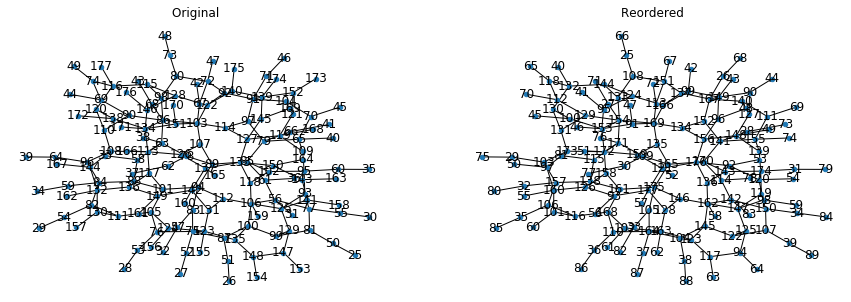

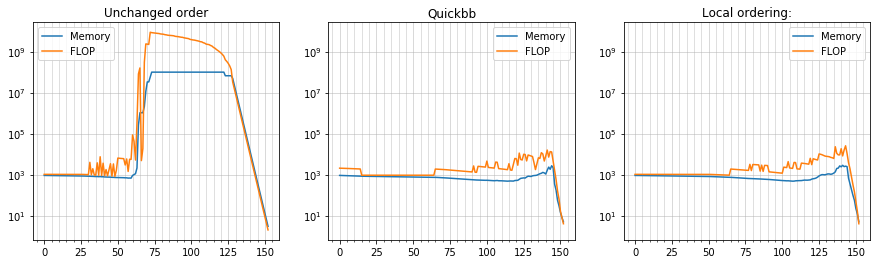

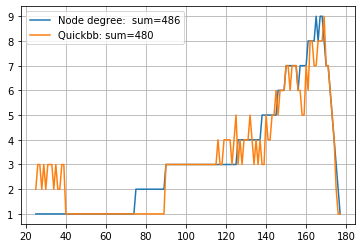

In [9]:
nqubits, circ = utils.test_circ('./test_circuits/', 5, depth=15)
graph = qtree.graph_model.circ2graph(nqubits, circ)

profile_grpaph(graph)

In [3]:
nqubits, circ = utils.test_circ('./test_circuits/', 6, depth=30)
graph = qtree.graph_model.circ2graph(nqubits, circ)

#profile_grpaph(graph)

2020-03-02 16:43:29,121- INFO•	reading file ./test_circuits//inst/cz_v2/6x6/inst_6x6_30_0.txt
2020-03-02 16:43:29,137- INFO•	There are 36 qubits in circuit
2020-03-02 16:43:29,260- INFO•	Generated graph with 353 nodes and 696 edges


/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


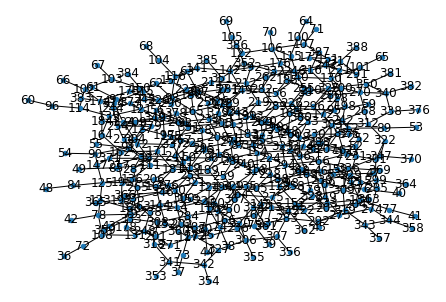

In [147]:
nx.draw_kamada_kawai(graph, node_size=20, with_labels=True)

In [158]:
def nn_tocliq(graph, node):
    tocl = utils.edges_to_clique(graph, node)
    nn = utils.n_neighbors(graph, node)
    return 1*nn + .1*tocl

peo, tw = qtree.graph_model.get_peo(graph)
print('Treewidth qbb:', tw)
npeo, nghs = get_locale_peo(graph, utils.n_neighbors)
npeo2, nghs2 = get_locale_peo(graph, nn_tocliq)
#print(npeo, nghs)#print(npeo2, nghs2)

2020-03-02 00:40:00,307- INFO•	generating config file output/quickbb.18684833.cnf
2020-03-02 00:40:00,309- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.18684833.cnf 


Treewidth qbb: 25


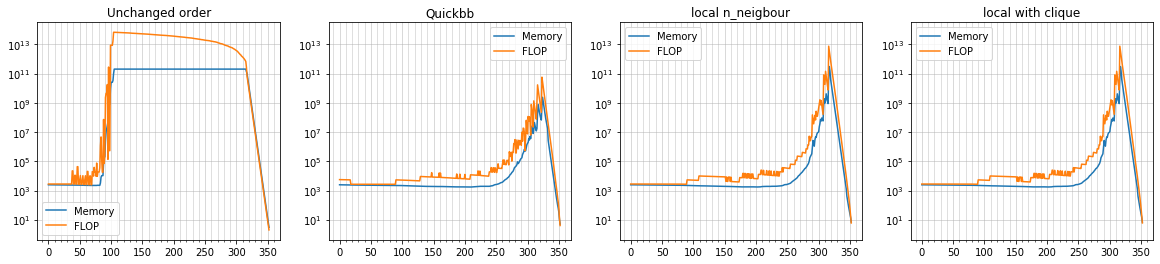

In [159]:
graph_opt, _ = utils.reorder_graph(graph, peo)
graph_opt_loc, _ = utils.reorder_graph(graph, npeo)
graph_opt_loc2, _ = utils.reorder_graph(graph, npeo2)

specs = [
    qtree.graph_model.cost_estimator(graph)
    , qtree.graph_model.cost_estimator(graph_opt)
    , qtree.graph_model.cost_estimator(graph_opt_loc)
    , qtree.graph_model.cost_estimator(graph_opt_loc2)
]
spec_titles = [
    'Unchanged order'
    ,'Quickbb'
    ,'local n_neigbour'
    ,'local with clique'
]


#-
f, axs = plt.subplots(1, len(specs), sharey=True, figsize=(5*len(specs),4))
for i, ax in enumerate(axs):
    plt.sca(ax)
    plt.title(spec_titles[i])
    utils.plot_cost(*specs[i])
   

local: 36, quickbb: 29


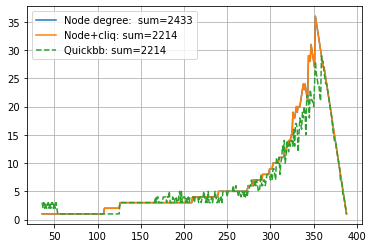

In [160]:
nodes, ngh_loc = utils.get_neighbours_path(graph_opt_loc)
nodes, ngh_loc2 = utils.get_neighbours_path(graph_opt_loc2)
nodes, ngh = utils.get_neighbours_path(graph_opt)

print(f'local: {max(ngh_loc)}, quickbb: {max(ngh)}')
plt.figure()
#-
plt.plot(nodes, ngh_loc, label=f'Node degree:  sum={sum(ngh_loc)}')
plt.plot(nodes, ngh_loc2, label=f'Node+cliq: sum={sum(ngh)}')
plt.plot(nodes, ngh, '--', label=f'Quickbb: sum={sum(ngh)}')
plt.grid()
plt.legend()

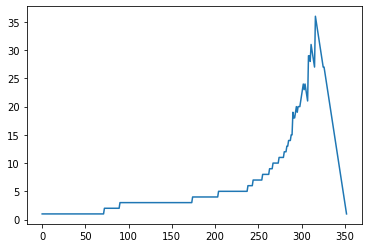

In [5]:
def nn_tocliq(graph, node):
    tocl = utils.edges_to_clique(graph, node)
    nn = utils.n_neighbors(graph, node)
    return 1*nn
npeo2, nghs2 = get_locale_peo(graph, nn_tocliq)
plt.plot(nghs2)

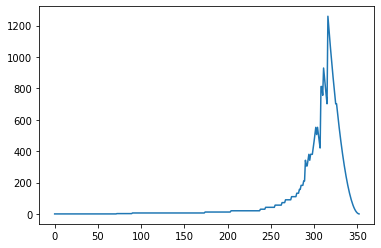

In [6]:
def nn_tocliq(graph, node):
    tocl = utils.edges_to_clique(graph, node)
    nn = utils.n_neighbors(graph, node)
    return tocl
npeo2, nghs2 = get_locale_peo(graph, nn_tocliq)
plt.plot(nghs2)